In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
%matplotlib inline
import torch
from deepseries.models import WaveNet, init
from deepseries.dataset import Property, TimeSeries, Seq2SeqDataLoader
from deepseries.nn.loss import MSELoss, RMSELoss
from deepseries.train import Learner
from deepseries.optim import ReduceCosineAnnealingLR
from torch.optim import Adam
from torch import nn
import matplotlib as mpl
from sklearn.metrics import mean_absolute_error
import chinese_calendar as calendar
import datetime as dt
info = pd.read_excel("./data/info.xlsx")
recored = info.set_index("contributor_id")['huangzf']
info = pd.read_excel("./data/info.xlsx").set_index("contributor_id")[['pjt_name', 'pjt_type']]
norm_score = pd.read_csv(r"./data/20200315_20200415.csv")

In [2]:
power = pd.read_csv('./data/df.csv', parse_dates=['data_time'])[['data_time', 'cid', 'value']]
power = power.set_index("data_time").groupby("cid").resample("1H").sum().reset_index()
power = power.pivot(index='cid', columns='data_time', values='value')
power = power.apply(np.log1p).iloc[:, 10000:]

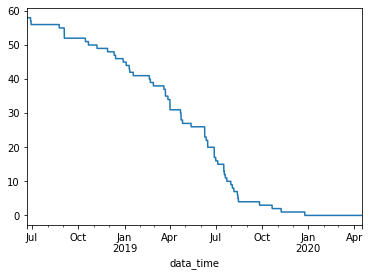

In [3]:
power.isnull().sum().plot()

In [4]:
is_zero = power.values == 0
is_nan = power.isnull().values
is_valid = ~is_zero & ~is_nan

xy = np.ma.masked_array(power.values, mask=~is_valid)

series_mu = xy.mean(axis=1).data.reshape(-1, 1)
series_std = xy.std(axis=1).data.reshape(-1, 1)
xy = (xy - series_mu) / series_std
xy = xy.filled(0.)

xy = np.expand_dims(xy, 1).astype('float32')

N_TEST = 24 * 30
N_VALID = 24 * 2
DROP_ZERO = True
DEC_LEN = 24 * 2
ENC_LEN = 24 * 7
time_free_space = 24

In [5]:
def n_lag(series, n):
    lag = np.zeros_like(series)
    lag[:, :, n:] = series[:, :, :-n]
    return lag

x_lag7 = n_lag(xy, 7 * 24)
x_lag14 = n_lag(xy, 14 * 24)

x_is_valid = np.expand_dims(is_valid, 1)

x_num_features = np.concatenate([x_lag7, x_lag14, x_is_valid], axis=1).astype("float32")

weights = x_is_valid.astype("float32") + 1e-6

In [6]:
def periodic_feature(x, T):
    psin = np.sin(x * np.pi * 2 / T)
    pcos = np.cos(x * np.pi * 2 / T)
    return np.stack([psin, pcos], axis=0)


xy_weekday = np.repeat(
    np.expand_dims(
        periodic_feature(power.columns.weekday.values, 7), axis=0), xy.shape[0], axis=0)

xy_hour = np.repeat(
    np.expand_dims(
        periodic_feature(power.columns.hour.values, 24), axis=0), xy.shape[0], axis=0)

xy_month = np.repeat(
    np.expand_dims(
        periodic_feature(power.columns.month.values, 12), axis=0), xy.shape[0], axis=0)

def get_holiday_features(dts):
    holidays = pd.get_dummies(pd.Series(dts).apply(lambda x: calendar.get_holiday_detail(x)[1]))
    holidays['sick'] = np.where((power.columns >= "2020-02-01") & (power.columns < "2020-03-01"), 1, 0)
    return holidays

holidays = get_holiday_features(power.columns)
holidays = np.expand_dims(holidays.values.transpose(1, 0), 0)
holidays = np.repeat(holidays, xy.shape[0], axis=0)

xy_num_features = np.concatenate([
    xy_weekday,
    xy_hour,
    xy_month,
    holidays
], axis=1).astype('float32')

In [7]:
xy_cat_features = np.expand_dims(np.arange(62), 1)

In [8]:
class ForwardSpliter:
    
    def split(self, time_idx, enc_len, dec_len, valid_size):
        if valid_size < 1:
            valid_size = int(np.floor(len(time_idx) * valid_size))
        valid_idx = time_idx[-(valid_size+enc_len):]
        train_idx = time_idx[:-valid_size]
        return train_idx, valid_idx
    
spliter = ForwardSpliter()
train_idx, valid_idx = spliter.split(np.arange(xy.shape[2]), ENC_LEN, DEC_LEN, N_TEST+N_VALID)
valid_idx, test_idx = spliter.split(valid_idx, ENC_LEN, DEC_LEN, N_TEST)

train_xy = TimeSeries(xy[:, :, train_idx])
valid_xy = TimeSeries(xy[:, :, valid_idx])

train_xy_features = TimeSeries(xy_num_features[:, :, train_idx])
valid_xy_features = TimeSeries(xy_num_features[:, :, valid_idx])
train_xy_cat = Property(xy_cat_features)

train_x_features = TimeSeries(x_num_features[:, :, train_idx])
valid_x_features = TimeSeries(x_num_features[:, :, valid_idx])
valid_xy_cat = Property(xy_cat_features)

train_weight = TimeSeries(weights[:, :, train_idx])
valid_weight = TimeSeries(weights[:, :, valid_idx])

train_frame = Seq2SeqDataLoader(train_xy, batch_size=16, enc_lens=ENC_LEN, dec_lens=DEC_LEN, use_cuda=True, mode='train', time_free_space=24,
                          enc_num_feats=[train_xy_features, train_x_features], dec_num_feats=[train_xy_features], weight=train_weight,
                               enc_cat_feats=[train_xy_cat], dec_cat_feats=[train_xy_cat])
valid_frame = Seq2SeqDataLoader(valid_xy, batch_size=64, enc_lens=ENC_LEN, dec_lens=DEC_LEN, use_cuda=True, mode='train', time_free_space=0,
                         time_interval=48, enc_num_feats=[valid_xy_features, valid_x_features], dec_num_feats=[valid_xy_features],
                               weight=valid_weight, dec_cat_feats=[valid_xy_cat], enc_cat_feats=[valid_xy_cat])

test_xy = xy[:, :, test_idx]
test_xf = np.concatenate([xy_num_features[:, :, test_idx], x_num_features[:, :, test_idx]], axis=1)
test_yf = xy_num_features[:, :, test_idx]
test_dec_cat = np.repeat(np.expand_dims(xy_cat_features, 2), DEC_LEN, axis=2)
test_enc_cat = np.repeat(np.expand_dims(xy_cat_features, 2), ENC_LEN, axis=2)

In [ ]:
model = WaveNet(enc_numerical=9+8, dec_numerical=6+8, dilations=[2 ** i for i in range(8)] * 3, 
                enc_categorical=[(63, 4)], dec_categorical=[(63, 4)],
                kernels_size=[2 for i in range(8)] * 3, dropout=0.1, debug=False, hidden_size=512)
opt = Adam(model.parameters(), 0.002)
loss_fn = MSELoss()
model.cuda()
lr_scheduler = ReduceCosineAnnealingLR(opt, 64)
learner = Learner(model, opt, loss_fn, './power_env', verbose=5000, lr_scheduler=lr_scheduler)
learner.fit(1500, train_frame, valid_frame, patient=64, start_save=1, early_stopping=False)

[[04/17/2020 02:29:31 PM]] start training >>>>>>>>>>>  see log: tensorboard --logdir ./power_env\logs
[[04/17/2020 02:29:47 PM]] epoch 1 / 1500, batch 100%, train loss 0.7077, valid loss 0.8818, cost time 0.3 minute
[[04/17/2020 02:30:03 PM]] epoch 2 / 1500, batch 100%, train loss 0.2022, valid loss 0.8265, cost time 0.3 minute
[[04/17/2020 02:30:20 PM]] epoch 3 / 1500, batch 100%, train loss 1.3467, valid loss 0.8543, cost time 0.3 minute
[[04/17/2020 02:30:35 PM]] epoch 4 / 1500, batch 100%, train loss 0.5549, valid loss 0.9117, cost time 0.2 minute
[[04/17/2020 02:30:54 PM]] epoch 5 / 1500, batch 100%, train loss 0.4673, valid loss 1.0189, cost time 0.3 minute
[[04/17/2020 02:31:15 PM]] epoch 6 / 1500, batch 100%, train loss 0.5247, valid loss 0.9762, cost time 0.3 minute
[[04/17/2020 02:31:32 PM]] epoch 7 / 1500, batch 100%, train loss 0.4313, valid loss 0.8357, cost time 0.3 minute
[[04/17/2020 02:31:52 PM]] epoch 8 / 1500, batch 100%, train loss 0.9421, valid loss 0.8128, cost ti

[[04/17/2020 02:51:12 PM]] epoch 71 / 1500, batch 100%, train loss 0.1225, valid loss 0.3488, cost time 0.3 minute
[[04/17/2020 02:51:27 PM]] epoch 72 / 1500, batch 100%, train loss 0.2543, valid loss 0.3493, cost time 0.3 minute
[[04/17/2020 02:51:44 PM]] epoch 73 / 1500, batch 100%, train loss 0.2309, valid loss 0.3531, cost time 0.3 minute
[[04/17/2020 02:52:00 PM]] epoch 74 / 1500, batch 100%, train loss 0.6476, valid loss 0.3488, cost time 0.3 minute
[[04/17/2020 02:52:16 PM]] epoch 75 / 1500, batch 100%, train loss 0.1153, valid loss 0.3434, cost time 0.3 minute
[[04/17/2020 02:52:33 PM]] epoch 76 / 1500, batch 100%, train loss 0.9232, valid loss 0.3489, cost time 0.3 minute
[[04/17/2020 02:52:52 PM]] epoch 77 / 1500, batch 100%, train loss 0.1074, valid loss 0.3506, cost time 0.3 minute
[[04/17/2020 02:53:09 PM]] epoch 78 / 1500, batch 100%, train loss 0.1454, valid loss 0.3478, cost time 0.3 minute
[[04/17/2020 02:53:28 PM]] epoch 79 / 1500, batch 100%, train loss 0.3991, valid

[[04/17/2020 03:11:54 PM]] epoch 141 / 1500, batch 100%, train loss 0.1833, valid loss 0.3487, cost time 0.3 minute
[[04/17/2020 03:12:10 PM]] epoch 142 / 1500, batch 100%, train loss 0.6651, valid loss 0.3746, cost time 0.3 minute
[[04/17/2020 03:12:27 PM]] epoch 143 / 1500, batch 100%, train loss 0.2449, valid loss 0.3431, cost time 0.3 minute
[[04/17/2020 03:12:46 PM]] epoch 144 / 1500, batch 100%, train loss 0.1318, valid loss 0.4273, cost time 0.3 minute
[[04/17/2020 03:13:06 PM]] epoch 145 / 1500, batch 100%, train loss 0.1972, valid loss 0.4802, cost time 0.3 minute
[[04/17/2020 03:13:23 PM]] epoch 146 / 1500, batch 100%, train loss 0.7110, valid loss 0.4660, cost time 0.3 minute
[[04/17/2020 03:13:44 PM]] epoch 147 / 1500, batch 100%, train loss 0.9265, valid loss 0.3659, cost time 0.4 minute
[[04/17/2020 03:14:00 PM]] epoch 148 / 1500, batch 100%, train loss 0.2779, valid loss 0.3438, cost time 0.3 minute
[[04/17/2020 03:14:21 PM]] epoch 149 / 1500, batch 100%, train loss 0.14

[[04/17/2020 03:32:17 PM]] epoch 211 / 1500, batch 100%, train loss 0.1116, valid loss 0.3209, cost time 0.3 minute
[[04/17/2020 03:32:38 PM]] epoch 212 / 1500, batch 100%, train loss 0.3730, valid loss 0.3210, cost time 0.3 minute
[[04/17/2020 03:32:57 PM]] epoch 213 / 1500, batch 100%, train loss 0.0725, valid loss 0.3158, cost time 0.3 minute
[[04/17/2020 03:33:16 PM]] epoch 214 / 1500, batch 100%, train loss 0.4981, valid loss 0.3064, cost time 0.3 minute
[[04/17/2020 03:33:34 PM]] epoch 215 / 1500, batch 100%, train loss 0.3158, valid loss 0.3023, cost time 0.3 minute
[[04/17/2020 03:33:49 PM]] epoch 216 / 1500, batch 100%, train loss 0.2973, valid loss 0.3024, cost time 0.2 minute
[[04/17/2020 03:34:04 PM]] epoch 217 / 1500, batch 100%, train loss 0.1287, valid loss 0.3037, cost time 0.2 minute
[[04/17/2020 03:34:21 PM]] epoch 218 / 1500, batch 100%, train loss 0.2442, valid loss 0.2983, cost time 0.3 minute
[[04/17/2020 03:34:39 PM]] epoch 219 / 1500, batch 100%, train loss 0.59

[[04/17/2020 03:52:35 PM]] epoch 281 / 1500, batch 100%, train loss 0.1041, valid loss 0.3662, cost time 0.3 minute
[[04/17/2020 03:52:53 PM]] epoch 282 / 1500, batch 100%, train loss 0.1239, valid loss 0.3626, cost time 0.3 minute
[[04/17/2020 03:53:09 PM]] epoch 283 / 1500, batch 100%, train loss 0.1737, valid loss 0.3539, cost time 0.3 minute
[[04/17/2020 03:53:26 PM]] epoch 284 / 1500, batch 100%, train loss 0.2014, valid loss 0.3255, cost time 0.3 minute
[[04/17/2020 03:53:43 PM]] epoch 285 / 1500, batch 100%, train loss 0.4329, valid loss 0.3011, cost time 0.3 minute
[[04/17/2020 03:54:00 PM]] epoch 286 / 1500, batch 100%, train loss 0.1878, valid loss 0.3007, cost time 0.3 minute
[[04/17/2020 03:54:21 PM]] epoch 287 / 1500, batch 100%, train loss 0.1138, valid loss 0.3096, cost time 0.4 minute
[[04/17/2020 03:54:43 PM]] epoch 288 / 1500, batch 100%, train loss 0.2095, valid loss 0.3112, cost time 0.4 minute
[[04/17/2020 03:55:00 PM]] epoch 289 / 1500, batch 100%, train loss 0.36

[[04/17/2020 04:13:05 PM]] epoch 351 / 1500, batch 100%, train loss 0.1010, valid loss 0.3078, cost time 0.3 minute
[[04/17/2020 04:13:22 PM]] epoch 352 / 1500, batch 100%, train loss 0.1541, valid loss 0.3130, cost time 0.3 minute
[[04/17/2020 04:13:37 PM]] epoch 353 / 1500, batch 100%, train loss 0.0716, valid loss 0.3066, cost time 0.3 minute
[[04/17/2020 04:13:55 PM]] epoch 354 / 1500, batch 100%, train loss 0.1051, valid loss 0.3023, cost time 0.3 minute
[[04/17/2020 04:14:12 PM]] epoch 355 / 1500, batch 100%, train loss 0.3067, valid loss 0.2970, cost time 0.3 minute
[[04/17/2020 04:14:33 PM]] epoch 356 / 1500, batch 100%, train loss 0.1511, valid loss 0.2888, cost time 0.3 minute
[[04/17/2020 04:14:47 PM]] epoch 357 / 1500, batch 100%, train loss 0.1746, valid loss 0.2920, cost time 0.2 minute
[[04/17/2020 04:15:11 PM]] epoch 358 / 1500, batch 100%, train loss 0.1531, valid loss 0.2966, cost time 0.4 minute
[[04/17/2020 04:15:25 PM]] epoch 359 / 1500, batch 100%, train loss 0.12

[[04/17/2020 04:33:35 PM]] epoch 421 / 1500, batch 100%, train loss 0.1637, valid loss 0.2871, cost time 0.2 minute
[[04/17/2020 04:33:55 PM]] epoch 422 / 1500, batch 100%, train loss 0.0959, valid loss 0.2864, cost time 0.3 minute
[[04/17/2020 04:34:15 PM]] epoch 423 / 1500, batch 100%, train loss 0.2257, valid loss 0.2853, cost time 0.3 minute
[[04/17/2020 04:34:36 PM]] epoch 424 / 1500, batch 100%, train loss 0.1847, valid loss 0.2895, cost time 0.3 minute
[[04/17/2020 04:34:52 PM]] epoch 425 / 1500, batch 100%, train loss 0.0932, valid loss 0.2884, cost time 0.3 minute
[[04/17/2020 04:35:09 PM]] epoch 426 / 1500, batch 100%, train loss 0.5861, valid loss 0.2878, cost time 0.3 minute
[[04/17/2020 04:35:25 PM]] epoch 427 / 1500, batch 100%, train loss 0.0844, valid loss 0.2910, cost time 0.3 minute
[[04/17/2020 04:35:42 PM]] epoch 428 / 1500, batch 100%, train loss 0.1350, valid loss 0.2906, cost time 0.3 minute
[[04/17/2020 04:36:01 PM]] epoch 429 / 1500, batch 100%, train loss 0.05

[[04/17/2020 04:54:15 PM]] epoch 491 / 1500, batch 100%, train loss 0.0374, valid loss 0.2920, cost time 0.3 minute
[[04/17/2020 04:54:30 PM]] epoch 492 / 1500, batch 100%, train loss 0.5558, valid loss 0.3040, cost time 0.2 minute
[[04/17/2020 04:54:45 PM]] epoch 493 / 1500, batch 100%, train loss 0.1170, valid loss 0.3093, cost time 0.3 minute
[[04/17/2020 04:55:02 PM]] epoch 494 / 1500, batch 100%, train loss 0.1433, valid loss 0.3057, cost time 0.3 minute
[[04/17/2020 04:55:24 PM]] epoch 495 / 1500, batch 100%, train loss 0.1220, valid loss 0.2979, cost time 0.4 minute
[[04/17/2020 04:55:38 PM]] epoch 496 / 1500, batch 100%, train loss 0.0850, valid loss 0.2968, cost time 0.2 minute
[[04/17/2020 04:55:53 PM]] epoch 497 / 1500, batch 100%, train loss 0.0401, valid loss 0.2887, cost time 0.3 minute
[[04/17/2020 04:56:10 PM]] epoch 498 / 1500, batch 100%, train loss 0.2295, valid loss 0.2919, cost time 0.3 minute
[[04/17/2020 04:56:24 PM]] epoch 499 / 1500, batch 100%, train loss 0.46

[[04/17/2020 05:16:00 PM]] epoch 561 / 1500, batch 100%, train loss 0.1923, valid loss 0.2822, cost time 0.4 minute
[[04/17/2020 05:16:23 PM]] epoch 562 / 1500, batch 100%, train loss 0.0645, valid loss 0.2745, cost time 0.4 minute
[[04/17/2020 05:16:41 PM]] epoch 563 / 1500, batch 100%, train loss 0.2320, valid loss 0.2753, cost time 0.3 minute
[[04/17/2020 05:17:04 PM]] epoch 564 / 1500, batch 100%, train loss 0.2555, valid loss 0.2736, cost time 0.4 minute
[[04/17/2020 05:17:22 PM]] epoch 565 / 1500, batch 100%, train loss 0.2688, valid loss 0.2794, cost time 0.3 minute
[[04/17/2020 05:17:40 PM]] epoch 566 / 1500, batch 100%, train loss 0.0885, valid loss 0.2765, cost time 0.3 minute
[[04/17/2020 05:18:00 PM]] epoch 567 / 1500, batch 100%, train loss 0.1864, valid loss 0.2716, cost time 0.3 minute
[[04/17/2020 05:18:18 PM]] epoch 568 / 1500, batch 100%, train loss 0.1378, valid loss 0.2762, cost time 0.3 minute
[[04/17/2020 05:18:35 PM]] epoch 569 / 1500, batch 100%, train loss 0.30

[[04/17/2020 05:37:59 PM]] epoch 631 / 1500, batch 100%, train loss 0.2768, valid loss 0.3017, cost time 0.3 minute
[[04/17/2020 05:38:21 PM]] epoch 632 / 1500, batch 100%, train loss 0.2119, valid loss 0.2924, cost time 0.4 minute
[[04/17/2020 05:38:39 PM]] epoch 633 / 1500, batch 100%, train loss 0.1039, valid loss 0.2883, cost time 0.3 minute
[[04/17/2020 05:38:52 PM]] epoch 634 / 1500, batch 100%, train loss 0.1999, valid loss 0.2935, cost time 0.2 minute
[[04/17/2020 05:39:12 PM]] epoch 635 / 1500, batch 100%, train loss 0.1509, valid loss 0.2958, cost time 0.3 minute
[[04/17/2020 05:39:31 PM]] epoch 636 / 1500, batch 100%, train loss 0.1436, valid loss 0.2862, cost time 0.3 minute
[[04/17/2020 05:39:51 PM]] epoch 637 / 1500, batch 100%, train loss 0.3435, valid loss 0.2970, cost time 0.3 minute
[[04/17/2020 05:40:09 PM]] epoch 638 / 1500, batch 100%, train loss 0.1174, valid loss 0.3133, cost time 0.3 minute
[[04/17/2020 05:40:26 PM]] epoch 639 / 1500, batch 100%, train loss 0.76

[[04/17/2020 05:59:12 PM]] epoch 701 / 1500, batch 100%, train loss 0.1739, valid loss 0.2745, cost time 0.2 minute
[[04/17/2020 05:59:32 PM]] epoch 702 / 1500, batch 100%, train loss 0.1201, valid loss 0.2761, cost time 0.3 minute
[[04/17/2020 05:59:52 PM]] epoch 703 / 1500, batch 100%, train loss 0.1588, valid loss 0.2787, cost time 0.3 minute
[[04/17/2020 06:00:14 PM]] epoch 704 / 1500, batch 100%, train loss 0.2140, valid loss 0.2775, cost time 0.4 minute
[[04/17/2020 06:00:35 PM]] epoch 705 / 1500, batch 100%, train loss 0.3873, valid loss 0.2740, cost time 0.4 minute
[[04/17/2020 06:01:01 PM]] epoch 706 / 1500, batch 100%, train loss 0.4073, valid loss 0.2738, cost time 0.4 minute
[[04/17/2020 06:01:21 PM]] epoch 707 / 1500, batch 100%, train loss 0.1656, valid loss 0.2757, cost time 0.3 minute
[[04/17/2020 06:01:39 PM]] epoch 708 / 1500, batch 100%, train loss 0.0520, valid loss 0.2769, cost time 0.3 minute
[[04/17/2020 06:01:55 PM]] epoch 709 / 1500, batch 100%, train loss 0.12

In [167]:
test_xy = torch.as_tensor(xy[:, :, test_idx]).cuda()
test_xf = torch.as_tensor(np.concatenate([xy_num_features[:, :, test_idx], x_num_features[:, :, test_idx]], axis=1)).cuda()
test_yf = torch.as_tensor(xy_num_features[:, :, test_idx]).cuda()

In [168]:
def plot(x_true, y_true, y_pred):
    enc_ticks = np.arange(x_true.shape[1])
    dec_ticks = np.arange(y_pred.shape[1]) + x_true.shape[1]
    for idx, name in enumerate(power.index):
        plt.figure(figsize=(12, 3))
        plt.plot(enc_ticks, x_true[idx])
        plt.plot(dec_ticks, y_pred[idx], label='pred')
        plt.plot(dec_ticks, y_true[idx], label='true')
        plt.title(name)
        plt.legend()

def wmape(y_hat, y):
    scores = []
    for day in range(int(y.shape[0] / 24)):
        scores.append(np.abs(y[day*24: (day+1)*24] - y_hat[day*24: (day+1)*24]).sum() / np.sum(y[day*24: (day+1)*24]))
    return scores

def metric(y_true, y_pred):
    scores = {}
    for idx, name in enumerate(power.index):
        scores[name] = wmape(y_pred[idx], y_true[idx])
    return pd.DataFrame(scores)

def wmape_dataframe(y_hat, y):
    scores = []
    for day in range(int(y.shape[0] / 96)):
        scores.append(np.abs(y[day*96: (day+1)*96] - y_hat[day*96: (day+1)*96]).sum() / np.sum(y[day*96: (day+1)*96]))
    return scores

def metric_dataframe(y_true, y_pred):
    scores = {}
    for idx, name in enumerate(power.index):
        scores[name] = wmape_dataframe(y_pred.iloc[idx], y_true.iloc[idx])
    return pd.DataFrame(scores)

def predict(learner, xy, x_feats, y_feats, epoch):
    learner.load(epoch)
    learner.model.eval()
    learner.model.cuda()
    preds = []
    days = int(xy.shape[2] / 24 - ENC_LEN / 24 - DEC_LEN/24 + 1)
    for day in range(days):
        step = day * 24
#         enc_start = day
#         enc_end = (step+ENC_LEN) / 24
#         dec_start = enc_end
#         dec_end = (step+ENC_LEN+DEC_LEN) / 24
#         print(f"start {enc_start}, end {int(dec_end)}" )
        step_pred = model(
            xy[:, :, step: step+ENC_LEN], 
            enc_num=x_feats[:, :, step: step+ENC_LEN],
            dec_num=y_feats[:, :, step+ENC_LEN: step+ENC_LEN+DEC_LEN], dec_len=DEC_LEN).cpu().detach().numpy()
        if step == 0:
            preds.append(step_pred)
        else:
            preds.append(step_pred[:, :, -24:])
    preds = np.concatenate(preds, axis=2)
    preds = np.expm1(preds.squeeze() * series_std + series_mu)
    
    x_true = np.expm1(xy[:, :, :ENC_LEN].cpu().numpy().squeeze() * series_std + series_mu)
    y_true = np.expm1(xy[:, :, ENC_LEN:].cpu().numpy().squeeze() * series_std + series_mu)
    
    return x_true, y_true, preds

In [181]:
norm_data = pd.read_csv("./data/20200315_20200415.csv").drop(['Unnamed: 0', 'model_name'], axis=1)
norm_data = norm_data[norm_data.contributor_id.isin(power.index)].reset_index(drop=True)
norm_data = norm_data.set_index("contributor_id").loc[power.index].reset_index()
norm_data['data_time'] = pd.to_datetime(norm_data.data_time)
norm_data = norm_data.set_index("data_time").groupby("contributor_id").resample('1H')[['forecast_pwr', 'value']].sum().reset_index()
norm_true = norm_data.pivot(index='contributor_id', columns='data_time', values='value').iloc[:, 48:]
norm_pred = norm_data.pivot(index='contributor_id', columns='data_time', values='forecast_pwr').iloc[:, 48:]


x_true, y_true, y_pred  = predict(learner, test_xy, test_xf, test_yf, 1014)
scores = pd.DataFrame([metric(y_true, y_pred).mean().rename("wave"), 
                       metric(norm_true.values, norm_pred.values).mean().rename("v1")]).T.dropna()

/home/zhouzr/anaconda3/envs/pytorch_1.3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


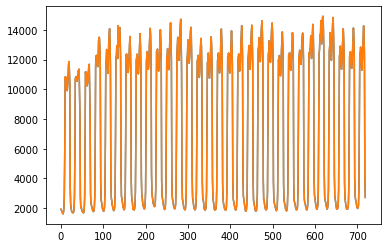

In [182]:
k = 1
plt.plot(y_true[k])
plt.plot(norm_true.values[k])

In [183]:
scores['best'] = scores.min(axis=1)

In [184]:
scores.mean()

wave    0.323410
v1      0.526637
best    0.279830
dtype: float64

In [186]:
scores.describe()

wave         v1       best
count  62.000000  62.000000  62.000000
mean    0.323410   0.526637   0.279830
std     0.472475   1.994470   0.477894
min     0.021604   0.017290   0.017290
25%     0.130351   0.089047   0.089047
50%     0.176902   0.171180   0.162188
75%     0.348363   0.306400   0.292094
max     3.451963  15.607201   3.451963

/home/zhouzr/anaconda3/envs/pytorch_1.3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


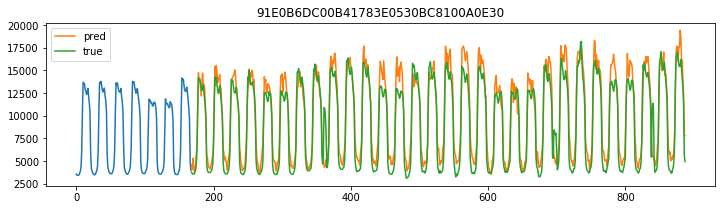

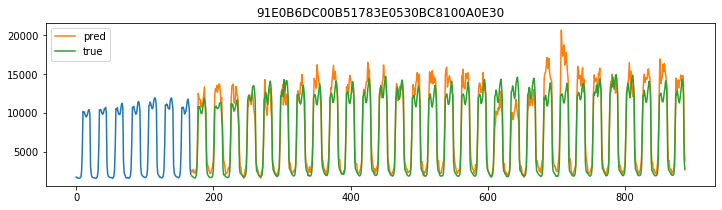

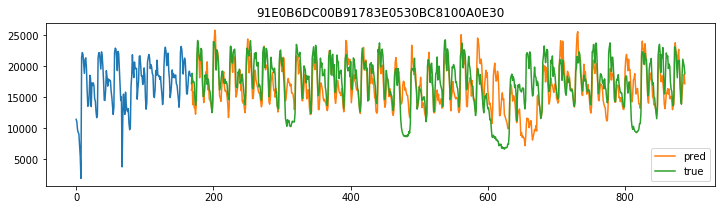

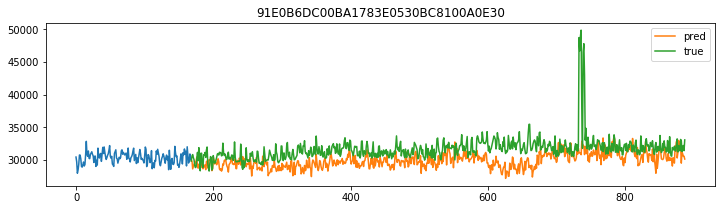

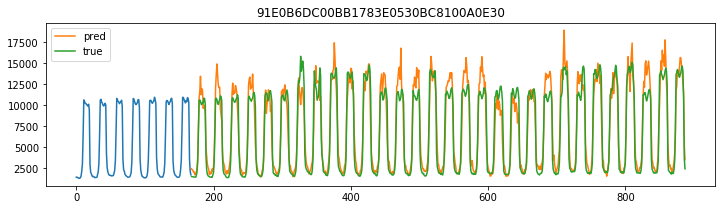

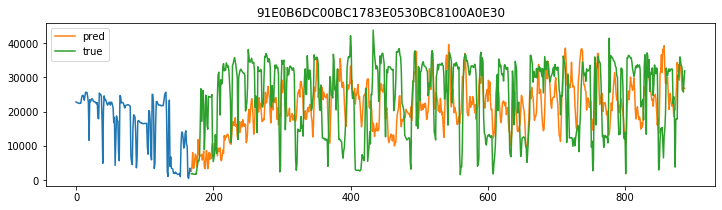

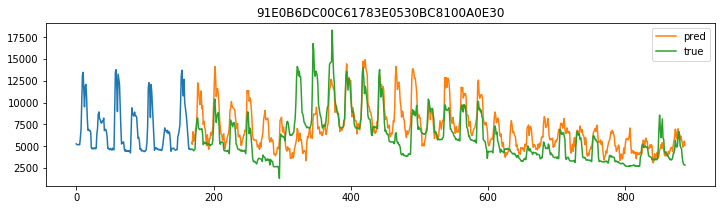

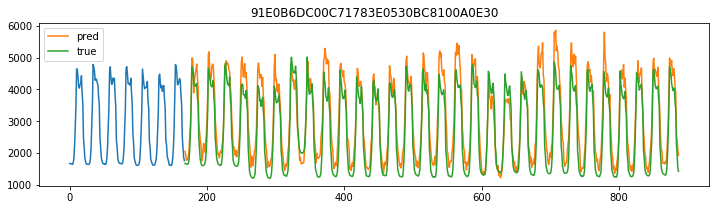

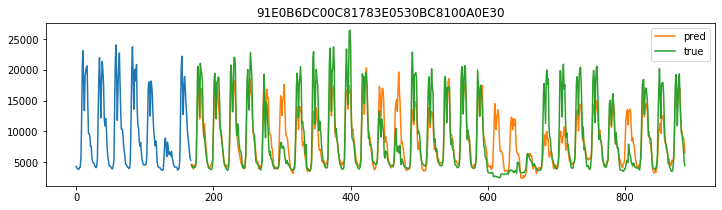

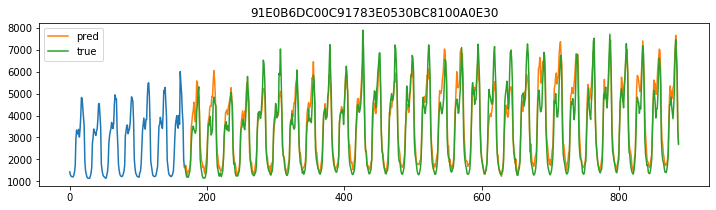

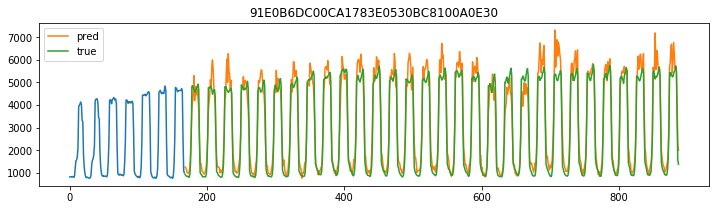

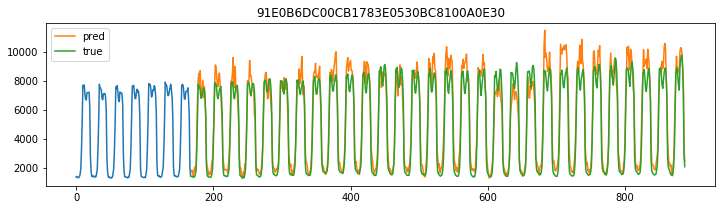

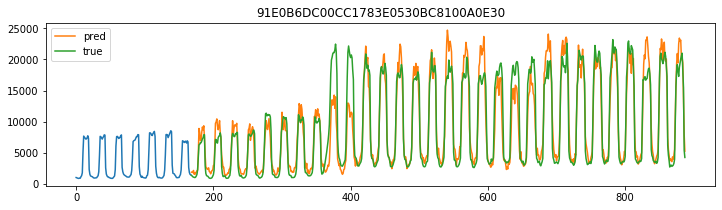

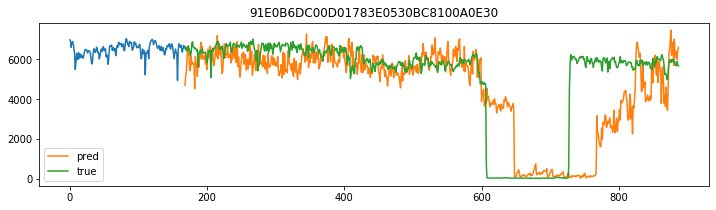

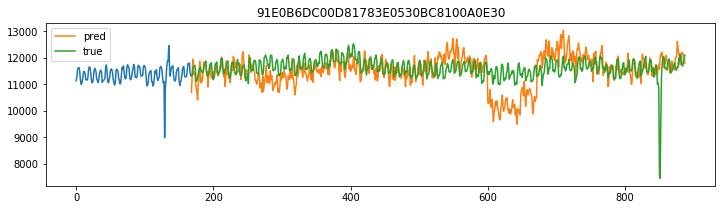

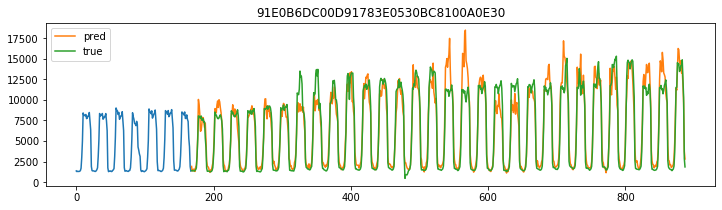

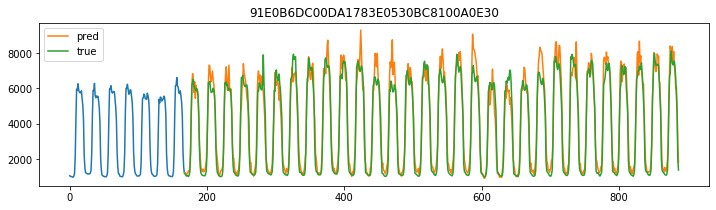

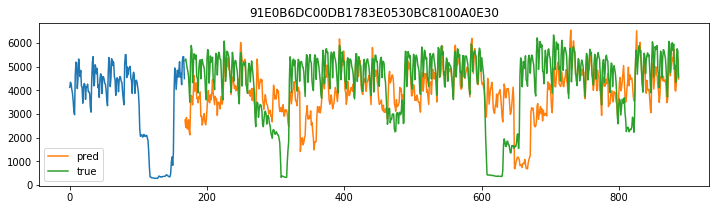

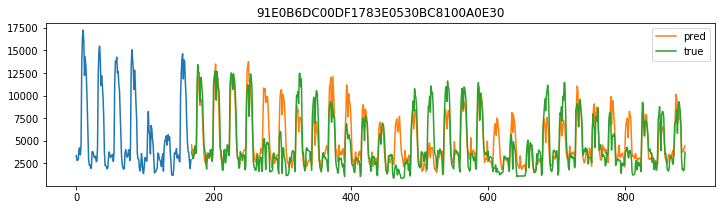

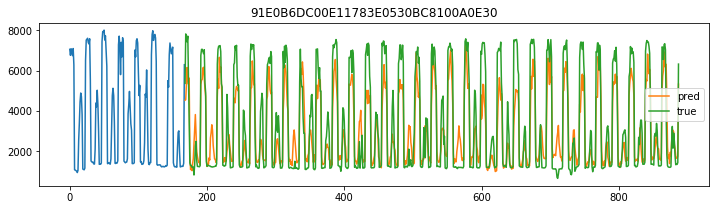

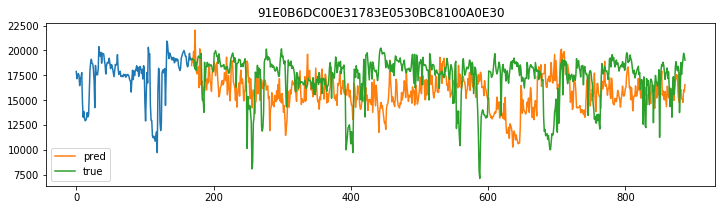

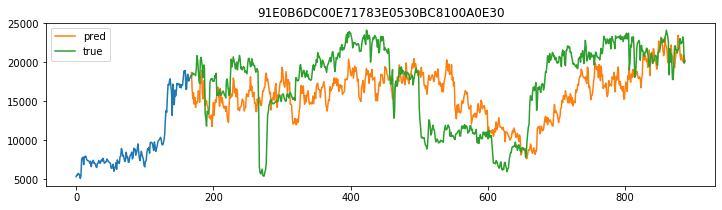

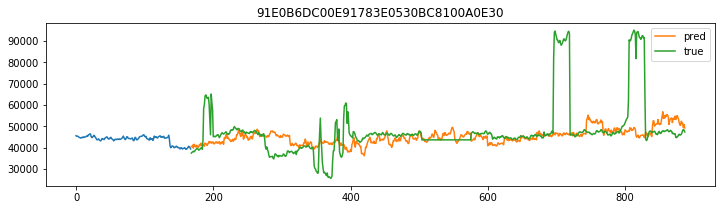

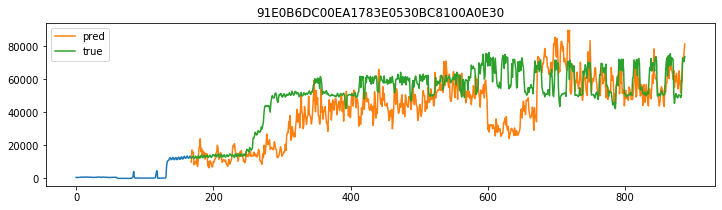

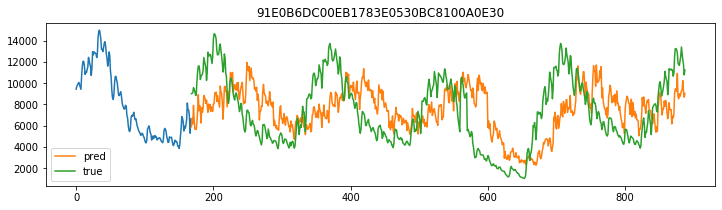

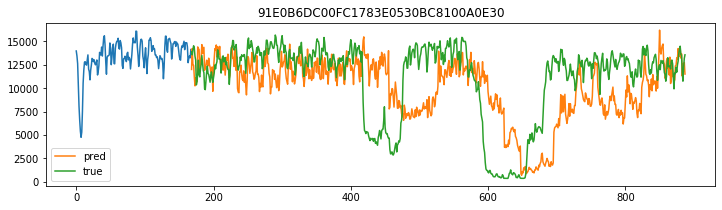

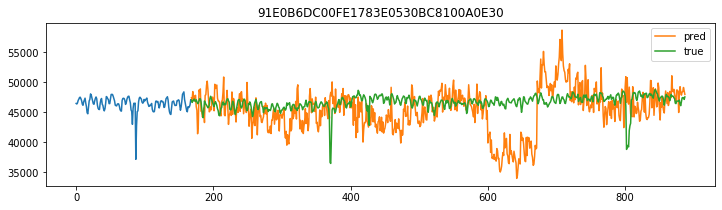

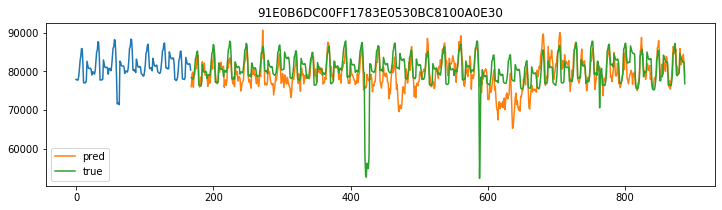

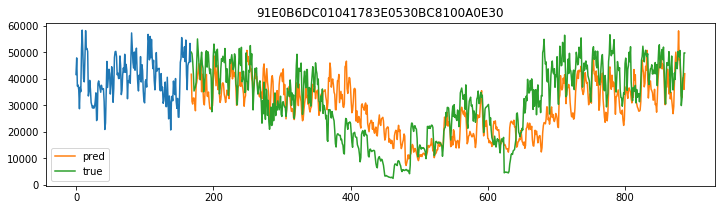

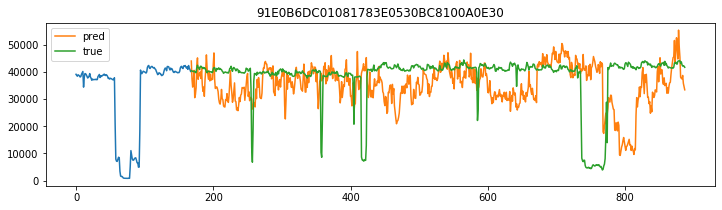

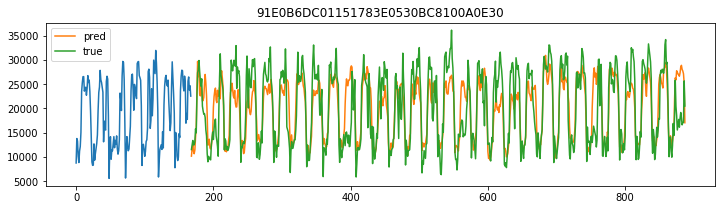

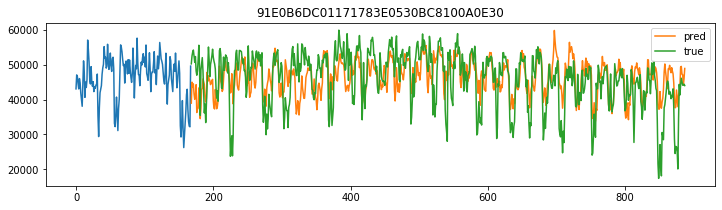

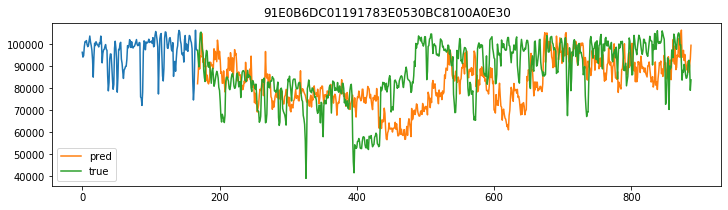

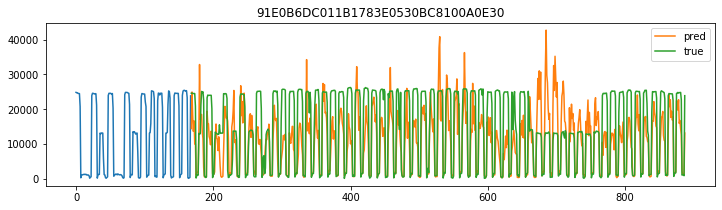

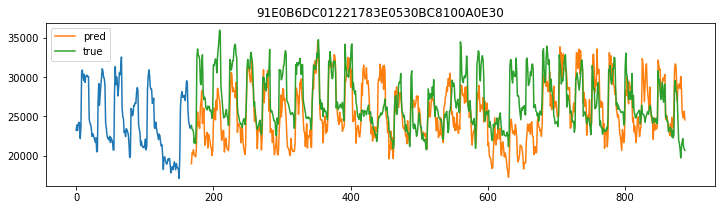

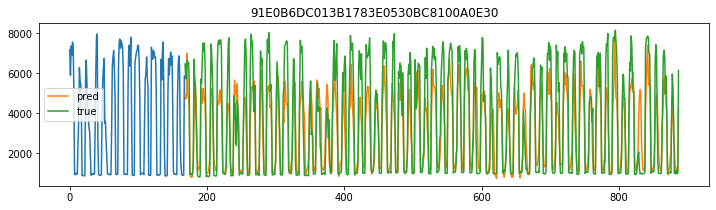

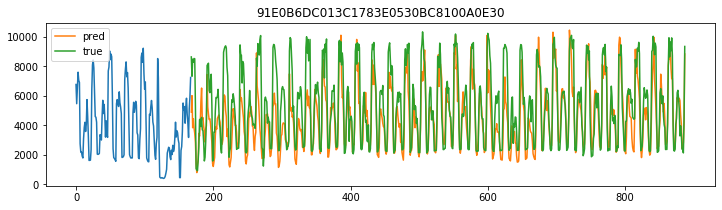

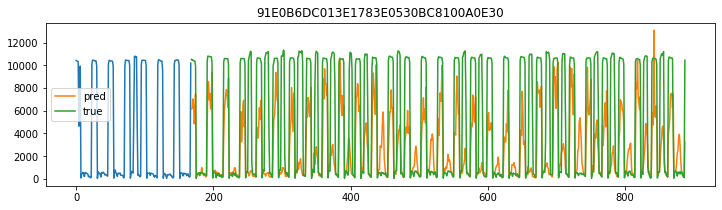

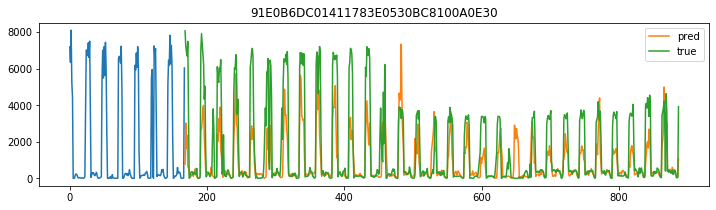

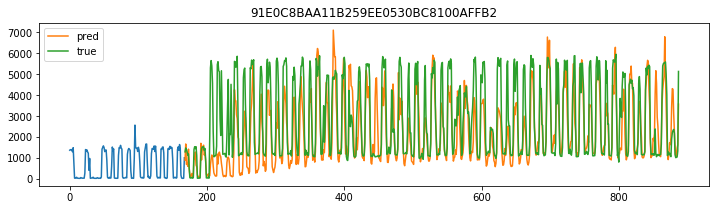

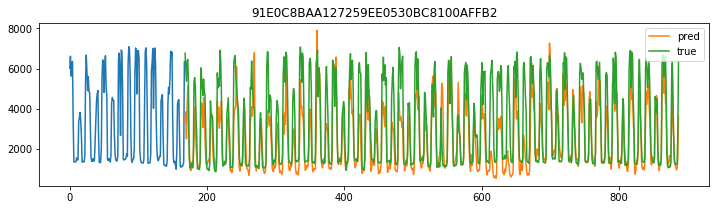

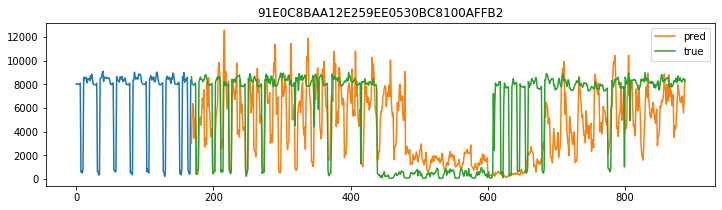

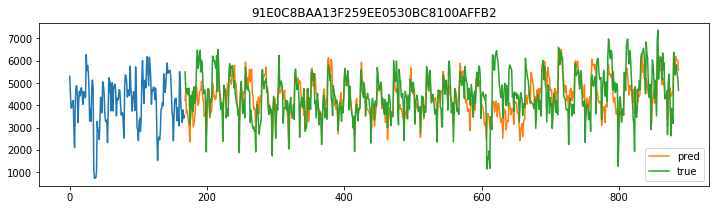

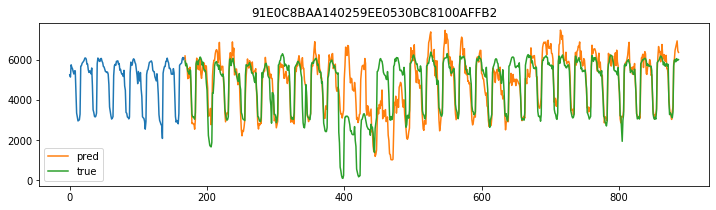

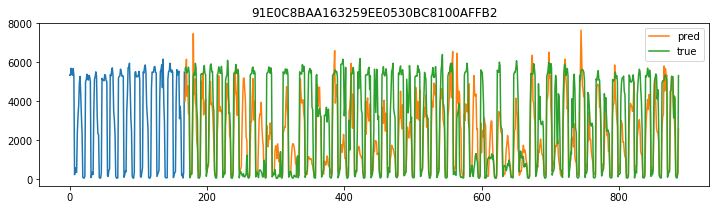

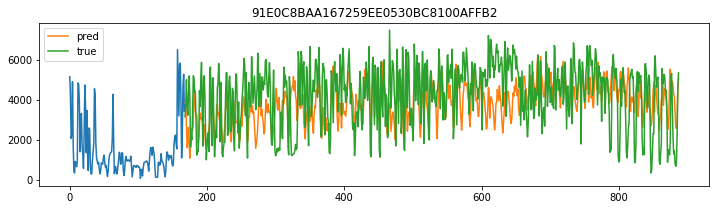

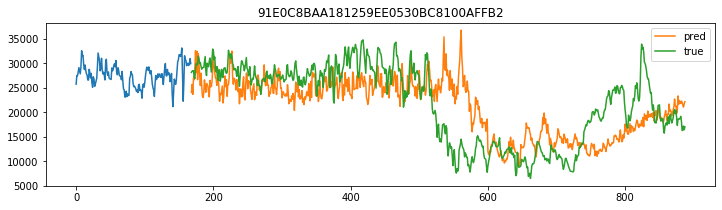

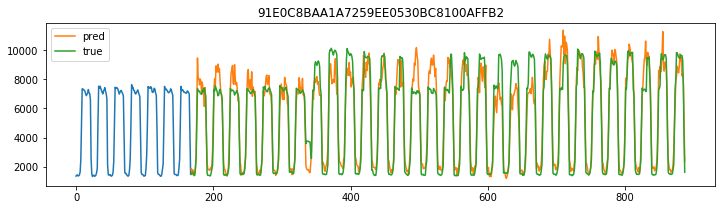

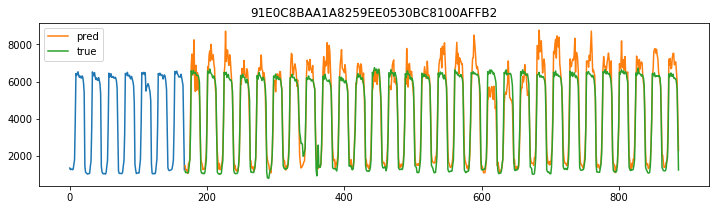

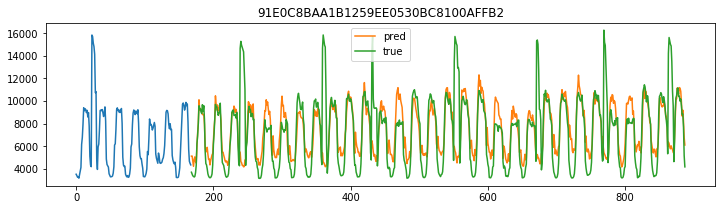

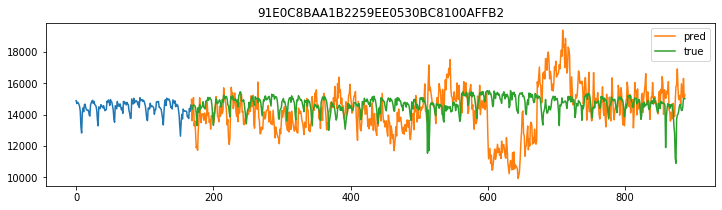

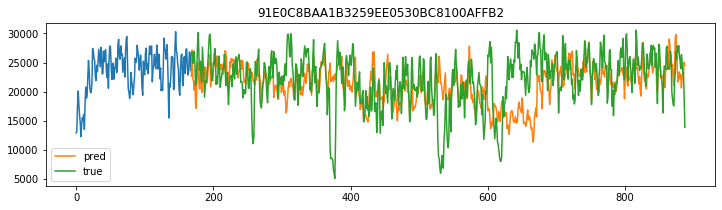

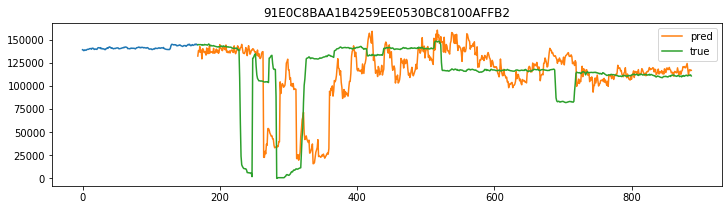

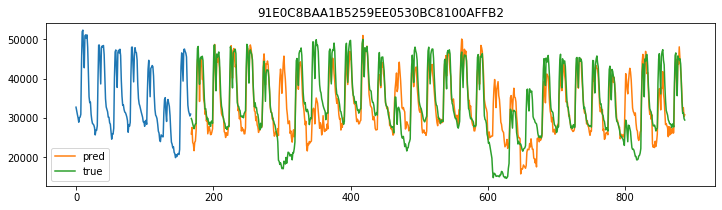

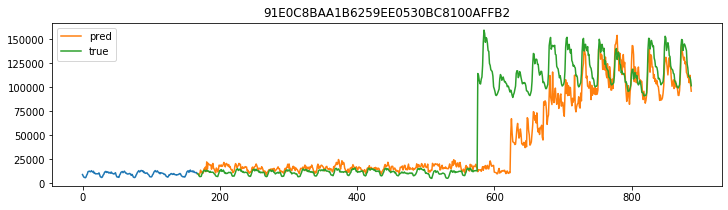

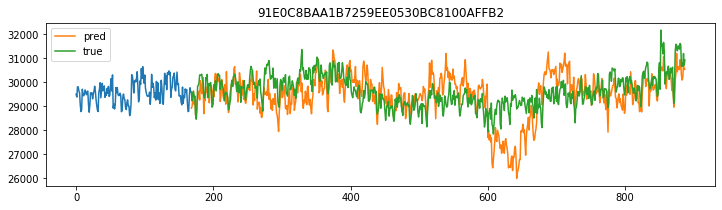

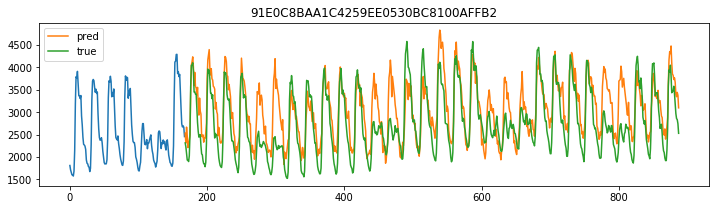

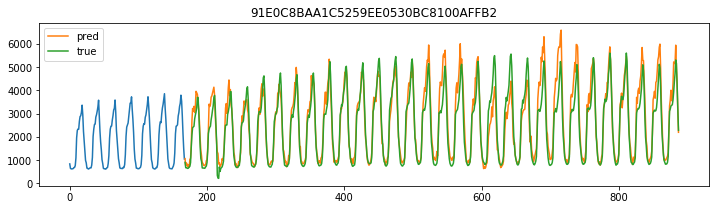

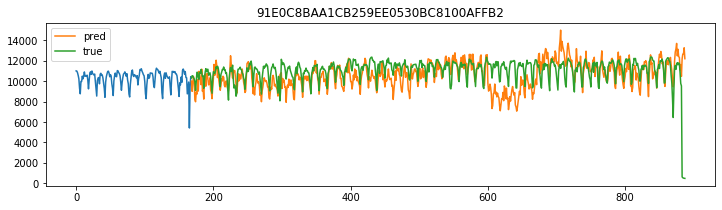

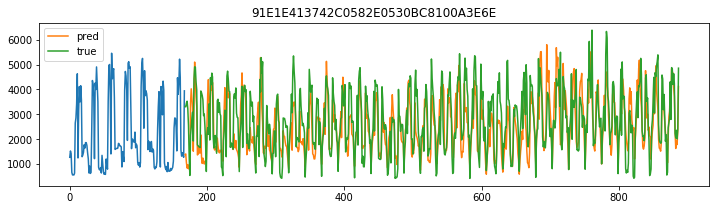

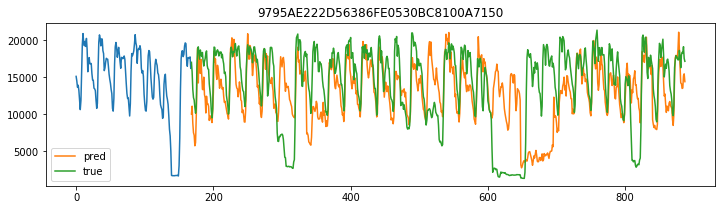

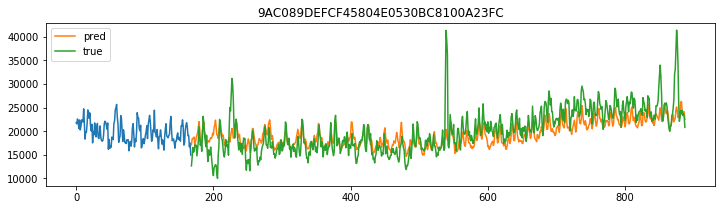

In [185]:
plot(x_true, y_true, y_pred)

In [187]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [188]:
get_n_params(learner.model)

795841